# Northern Rangelands Trust Community Conservancy Vegetation Index Analysis

This notebook prepares and analysis vegetation index data for community conservancies in northern Kenya.

The aim of this notebook is to aggregate vegetation index data from satellites, in the form of the Normalised Difference Vegetation Index (NDVI) and the Enhanced Vegetation Index (EVI), for each of the conservancies.

The timeseries of vegetation indices can be used to analyse and identify trends in vegetation presence and health. They can also be used to quantify and understand phenological patterns.

## Install and import packages

In [1]:
!pip install odc-stac pystac_client session-info matplotlib rioxarray datacube xagg odc.algo --quiet

In [32]:
import matplotlib.pyplot as plt
import session_info
import numpy as np
import geopandas as gpd
import rioxarray
import odc.algo
import xagg as xa
import datacube

from datacube.utils import masking
from pystac_client import Client
from odc.stac import configure_rio, stac_load

In [3]:
session_info.show()

/usr/local/lib/python3.11/dist-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


## Load Community Conservancy Polygons

We load community conservancy polygons from the Northern Rangelands Trust, within which we will be conducting the analyses and data preparation.

Ensure that the shapefile and associated files are stored in a local directory called 'data'.

<Axes: >

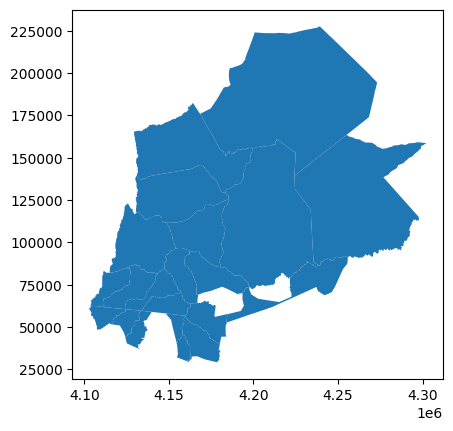

In [4]:
nrt_cc = gpd.read_file('data/NRT_Carbon.shp')

nrt_cc.plot()

We can inspect the information contained in the Geopandas object. It contains the name of the conservancy, its area, population (male and female), and number of households.

In [5]:
nrt_cc.head()

,NAME,Area_Acres,County,YearEstabl,TotalPopul,Male,Female,Households,Area_Ha,geometry
0,Naapu,69842.1452998588,Isiolo,None,3378,1621,1757,709,28264.1134260928,"POLYGON ((4147319.534 84274.138, 4147326.852 8..."
1,Nanapa,62920.2010639737,Isiolo,None,6907,3276,3631,1534,25462.9019774441,"POLYGON ((4111441.019 66487.18, 4111426.862 66..."
2,Narupa,91487.3363723155,Isiolo,None,5206,2468,2738,1097,37023.6114766574,"POLYGON ((4128259.354 66582.55, 4128258.296 66..."
3,Nanapisho,61158.3230186806,Isiolo,None,4646,2219,2427,976,24749.8952291361,"POLYGON ((4157461.157 70132.6, 4157461.158 701..."
4,Kalepo,449241.793521901,Samburu,None,7585,3738,3847,1791,181801.70373246,"POLYGON ((4183623.317 129002.216, 4183510.831 ..."


### Select conservancy for analysis

Due to data volumes, this notebook deals with one selected conservancy only, which can be alternated. The cell below selects the conservancy we'll be dealing with and prints its name.

In [6]:
selected_cc_ix = 0 # select the conservancy by changing this index number

nrt_cc.iloc[selected_cc_ix].NAME

'Naapu'

## Access Digital Earth Africa Monthly NDVI

Next, we set the configuration for the [Digital Earth Africa mean NDVI and anomaly product](https://www.digitalearthafrica.org/platform-resources/services/mean-ndvi-and-anomalies). This product provides us with an 'off-the-shelf' NDVI mean and anomaly value for every month from January 2017 to present.  

In [7]:
config = {
    "ndvi_anomaly": {
        "assets": {
            "*": {
                "data_type": "float32",
                "nodata": 'nan',
                "unit": "1",
            },
        },
    }
}

To access Digital Earth Africa data, we set the AWS endpoint and STAC catalog.

In [8]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

### Loading parameters

Next, we define the parameters for loading the NDVI data. We use the selected conservancy boundary. The start date is set as the beginning of 2013, although the product is only available from 2017.

In [9]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = nrt_cc.to_crs('EPSG:4326').iloc[selected_cc_ix].geometry.bounds

# Set a start and end date
start_date = "2013-01-01"
end_date = "2024-12-31"

# Set the STAC collections
collections = ["ndvi_anomaly"]

Now that the configuration is set, we can query the database and print the number of STAC items returned.

In [10]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 190 datasets


### Load NDVI data

NDVI data is loaded below with reference to the STAC items. We set the resolution as 30m, the native resolution of the NDVI mean and anomaly data.

This returns an xarray object which we can see contains space and time dimensions and `ndvi_mean` as a measurement or variable.

In [11]:
crs = "EPSG:6933"
resolution = 30

ds = stac_load(
    items,
    bands=("ndvi_mean"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 347MB
Dimensions:      (y: 956, x: 956, time: 95)
Coordinates:
  * y            (y) float64 8kB 9.722e+04 9.718e+04 ... 6.86e+04 6.856e+04
  * x            (x) float64 8kB 3.575e+06 3.575e+06 ... 3.603e+06 3.603e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 760B 2017-01-01 2017-02-01 ... 2024-11-01
Data variables:
    ndvi_mean    (time, y, x) float32 347MB dask.array<chunksize=(1, 956, 956), meta=np.ndarray>

### Plot mean NDVI

We can plot NDVI for a selected time point, noting the data covers the entire bounding box of the conservancy we queried.

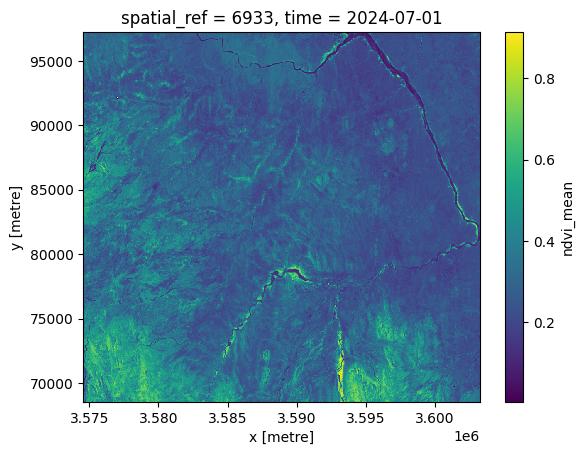

In [12]:
ds.ndvi_mean.isel(time=90).plot()

### Clip NDVI to conservancy

We use the `rioxarray` package to clip the NDVI data to the bounds of the conservancy of interest.

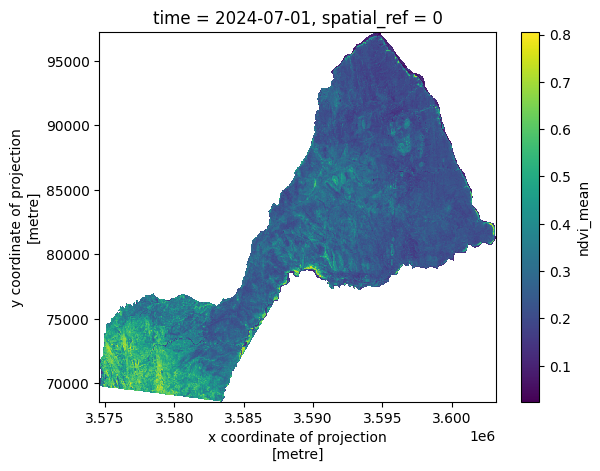

In [13]:
ds_clip = ds.rio.clip(gpd.GeoDataFrame(nrt_cc.iloc[0]).transpose().set_geometry('geometry').geometry.values, nrt_cc.crs)

ds_clip.ndvi_mean.isel(time=90).plot()

### Plot time series

Next, we can plot the timeseries of NDVI values (spatial mean) from 2017 to 2024. We first creat a timeseries object, `ts`, then omit any 0 values, which reflect empty dates.

<Axes: xlabel='time'>

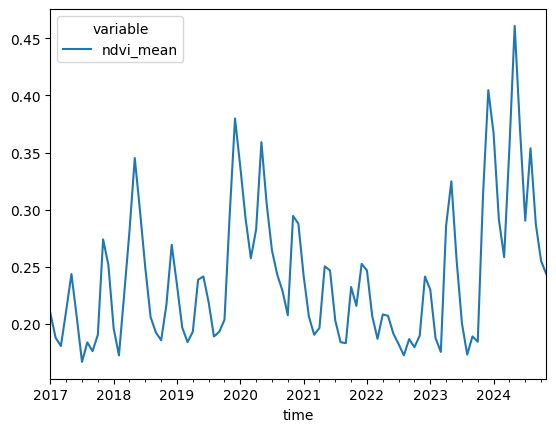

In [14]:
ts = ds_clip.mean(["y", "x"]).to_array().to_pandas().transpose()

ts = ts[ts.ndvi_mean>0]
ts.plot()

## Load Landsat data

The NDVI mean and anomaly product begins in 2017 because this was when the Sentinel-2 satellite was launched, and the product combines data from Landsat and Sentinel-2.

In this instance, we are interested in a period from 2013, so we must use Landsat. We set the configuration and search the STAC catalog in a similar manner to the NDVI product.

In [15]:
config = {
    "ls8_sr": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "QA_PIXEL": {
                "data_type": "uint16",
                "nodata": 1,
                "unit": "bit_index",
            },
        },
    }
}

Next, we search the STAC catalog for datasets that match our query. Given the time period we set from 2017 to  2024, we can use Landsat-8 and Landsat-9.

In [16]:
# Set the STAC collections
collections = ["ls8_sr", "ls9_sr"]

# Set a start and end date
start_date = "2013-01-01"
end_date = "2024-12-31"

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 1015 datasets


The cell below loads data from the STAC items returned. We load the bands we need to calculate the Enhanced Vegetation Index (EVI) and the quality pixel band to conduct cloud masking.

In [17]:
crs = "EPSG:6933"
resolution = 100

ds = stac_load(
    items,
    bands=("SR_B2", "SR_B4", "SR_B5", "QA_PIXEL"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 449MB
Dimensions:      (y: 288, x: 288, time: 676)
Coordinates:
  * y            (y) float64 2kB 9.725e+04 9.715e+04 ... 6.865e+04 6.855e+04
  * x            (x) float64 2kB 3.575e+06 3.575e+06 ... 3.603e+06 3.603e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 5kB 2013-04-02T07:47:21.252490 ... 202...
Data variables:
    SR_B2        (time, y, x) uint16 112MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>
    SR_B4        (time, y, x) uint16 112MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>
    SR_B5        (time, y, x) uint16 112MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>
    QA_PIXEL     (time, y, x) uint16 112MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>

### Cloud masking

We have to define the cloud mask band attributes to conduct cloud masking. These can be found in the [definition documentation](https://explorer.digitalearth.africa/products/ls9_sr#definition-doc) on Digital Earth Africa Explorer.

In [18]:
ds.QA_PIXEL.attrs = {'units': 'bit_index',
                    'nodata': 1,
                    'flags_definition': {'snow': {'bits': 5,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'clear': {'bits': 6, 'values': {'0': False, '1': True}},
                      'cloud': {'bits': 3,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'water': {'bits': 7, 'values': {'0': 'land_or_cloud', '1': 'water'}},
                      'cirrus': {'bits': 2,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'nodata': {'bits': 0, 'values': {'0': False, '1': True}},
                      'cloud_shadow': {'bits': 4,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'dilated_cloud': {'bits': 1, 'values': {'0': 'not_dilated', '1': 'dilated'}},
                      'cloud_confidence': {'bits': [8, 9],
                      'values': {'0': 'none', '1': 'low', '2': 'medium', '3': 'high'}},
                      'cirrus_confidence': {'bits': [14, 15],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}},
                      'snow_ice_confidence': {'bits': [12, 13],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}},
                      'cloud_shadow_confidence': {'bits': [10, 11],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}}},
                    'crs': 'epsg:32633',
                    'grid_mapping': 'spatial_ref'}

### Rename bands

We rename the surface reflectance bands to their common names, blue, red, and NIR, to make it easy to deal with them and calculate indices.

In [19]:
dict_names = dict(SR_B2="blue", SR_B4="red", SR_B5="nir")

ds = ds.rename(dict_names)

The cell below conducts the cloud masking. We can enter the minimum amount of 'good data'. Scenes are omitted where the proportion of good data (clear pixels) is lower than the threshold entered.

In [20]:
min_gooddata = 0.8

categories_to_mask_ls=dict(
        cloud="high_confidence", cloud_shadow="high_confidence"
    )

mask, _ = masking.create_mask_value(
  ds['QA_PIXEL'].attrs["flags_definition"], **categories_to_mask_ls
  )

pq_mask = (ds['QA_PIXEL'] & mask) != 0

data_perc = (~pq_mask).sum(axis=[1, 2], dtype="int32") / (
            pq_mask.shape[1] * pq_mask.shape[2]
        )

keep = (data_perc >= min_gooddata).persist()

# Filter by `min_gooddata` to drop low quality observations
total_obs = len(ds.time)
ds = ds.sel(time=keep)
pq_mask = pq_mask.sel(time=keep)

ds = odc.algo.erase_bad(ds, where=pq_mask)

ds

/usr/local/lib/python3.11/dist-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


<xarray.Dataset> Size: 368MB
Dimensions:      (y: 288, x: 288, time: 554)
Coordinates:
  * y            (y) float64 2kB 9.725e+04 9.715e+04 ... 6.865e+04 6.855e+04
  * x            (x) float64 2kB 3.575e+06 3.575e+06 ... 3.603e+06 3.603e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 4kB 2013-04-07T07:43:17.975023 ... 202...
Data variables:
    blue         (time, y, x) uint16 92MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>
    red          (time, y, x) uint16 92MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>
    nir          (time, y, x) uint16 92MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>
    QA_PIXEL     (time, y, x) uint16 92MB dask.array<chunksize=(1, 288, 288), meta=np.ndarray>

Following the cloud masking, we clip the images to the community conservancy of interest.

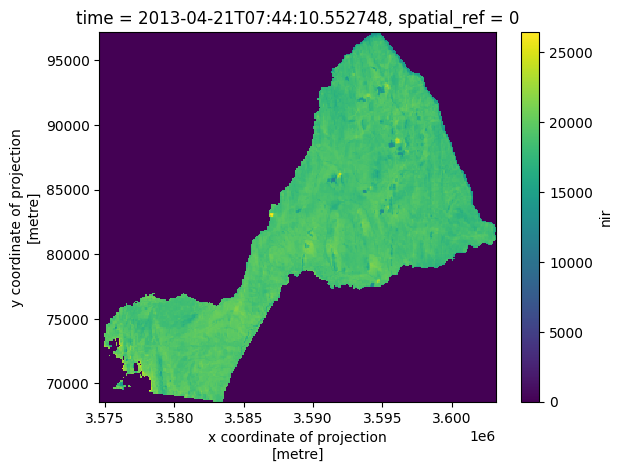

In [21]:
ds = ds.rio.clip(gpd.GeoDataFrame(nrt_cc.iloc[0]).transpose().set_geometry('geometry').geometry.values, nrt_cc.crs)

ds.isel(time=2).nir.plot()

## Calculate Enhanced Vegetation Index

Before calculating an EVI band, we first need to re-scale the reflectance bands to their true values. We can find the values used on the [USGS website](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products).

In [22]:
ds[['blue', 'red', 'nir']] = 2.75e-5 * ds[['blue', 'red', 'nir']] - 0.2

We can then calculate the EVI, again referring to [USGS guidance](https://www.usgs.gov/landsat-missions/landsat-enhanced-vegetation-index) on how to use each band to calculate.

In [23]:
ds['EVI'] = 2.5 * ((ds.nir - ds.red)/(ds.nir + 6*ds.red - 7.5 * ds.blue + 1))
ds

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 286, x: 286, time: 554)
Coordinates:
  * y            (y) float64 2kB 9.715e+04 9.705e+04 ... 6.875e+04 6.865e+04
  * x            (x) float64 2kB 3.575e+06 3.575e+06 ... 3.603e+06 3.603e+06
  * time         (time) datetime64[ns] 4kB 2013-04-07T07:43:17.975023 ... 202...
    spatial_ref  int64 8B 0
Data variables:
    blue         (time, y, x) float64 363MB dask.array<chunksize=(1, 286, 286), meta=np.ndarray>
    red          (time, y, x) float64 363MB dask.array<chunksize=(1, 286, 286), meta=np.ndarray>
    nir          (time, y, x) float64 363MB dask.array<chunksize=(1, 286, 286), meta=np.ndarray>
    QA_PIXEL     (time, y, x) uint16 91MB dask.array<chunksize=(1, 286, 286), meta=np.ndarray>
    EVI          (time, y, x) float64 363MB dask.array<chunksize=(1, 286, 286), meta=np.ndarray>

To assist with memory management we drop the variables that we don't need anymore.

In [24]:
ds = ds.drop_vars(["red", "blue", "nir", "QA_PIXEL"])
ds

<xarray.Dataset> Size: 363MB
Dimensions:      (y: 286, x: 286, time: 554)
Coordinates:
  * y            (y) float64 2kB 9.715e+04 9.705e+04 ... 6.875e+04 6.865e+04
  * x            (x) float64 2kB 3.575e+06 3.575e+06 ... 3.603e+06 3.603e+06
  * time         (time) datetime64[ns] 4kB 2013-04-07T07:43:17.975023 ... 202...
    spatial_ref  int64 8B 0
Data variables:
    EVI          (time, y, x) float64 363MB dask.array<chunksize=(1, 286, 286), meta=np.ndarray>

The cell below aggregates the average of EVI values across space to produce a time series.

In [25]:
ds = ds.mean(["y", "x"])

ts = ds.to_array().to_pandas().transpose()

ts = ts[ts.EVI>0]

## Plot EVI time series

Plotting the time series of EVI values from 2013 to 2024 gives an early indication of any trends that may be present.

<Axes: xlabel='time'>

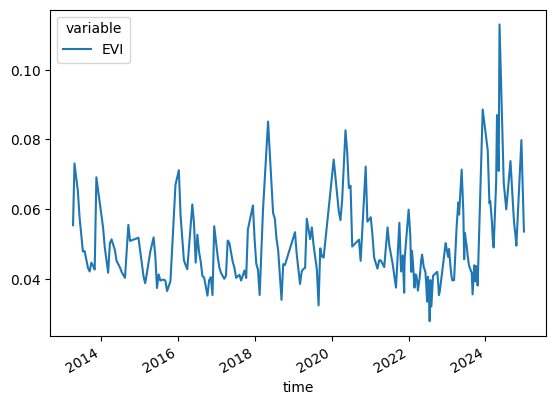

In [27]:
ts.plot()

Finally, we export the time series of EVI as a .csv file.

In [29]:
ts.to_csv(f'outputs/{nrt_cc.iloc[0].NAME}_ts.csv')

# Conclusion

This notebook has shown how to generate an EVI time series for a period and community conservancy of interest. Further notebooks will analyse fractional cover in each conservancy and look at more robust trend analysis.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [33]:
print(datacube.__version__)

1.9.4


**Last Tested:**

In [34]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-06-05'